In [2]:
import os
import json
import numpy as np
from collections import defaultdict
import pprint
from nltk.translate.bleu_score import sentence_bleu

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

import nltk
from matplotlib.pyplot import figure

In [3]:
v0_out = '/root/data/home/hoyeung/blob_alfred_data/exp_all/model:seq2seq_nl_baseline,name:v0_epoch_50_low_level_instrs'
v1_out = '/root/data/home/hoyeung/blob_alfred_data/exp_all/model:seq2seq_nl_with_frames,name:v1_epoch_50_low_level_instrs'

In [4]:
epoch = 49

## Load debug data

In [5]:
path = os.path.join(v0_out, 'valid_seen_argmax.debug_epoch_{}.preds.json'.format(epoch))
with open(path, 'r') as f:
    v0_debug_valid_seen = json.load(f)
    
path = os.path.join(v0_out, 'valid_unseen_argmax.debug_epoch_{}.preds.json'.format(epoch))
with open(path, 'r') as f:
    v0_debug_valid_unseen = json.load(f)
    
path = os.path.join(v0_out, 'train_sanity_argmax.debug_epoch_{}.preds.json'.format(epoch))
with open(path, 'r') as f:
    v0_debug_train_sanity = json.load(f)
    

path = os.path.join(v1_out, 'valid_seen_argmax.debug_epoch_{}.preds.json'.format(epoch))
with open(path, 'r') as f:
    v1_debug_valid_seen = json.load(f)
    
path = os.path.join(v1_out, 'valid_unseen_argmax.debug_epoch_{}.preds.json'.format(epoch))
with open(path, 'r') as f:
    v1_debug_valid_unseen = json.load(f)
    
path = os.path.join(v1_out, 'train_sanity_argmax.debug_epoch_{}.preds.json'.format(epoch))
with open(path, 'r') as f:
    v1_debug_train_sanity = json.load(f)

In [6]:
def preprocess_debug_data(debug_dat):

	p_vocab = defaultdict(int)
	ref_vocab = defaultdict(int)

	task_ids = []
	n_ref_tokens_all = []
	n_pred_tokens_all = []
	n_subgoals_all = []
	n_actions_all = []

	ref_tokens_all = []
	p_tokens_all = []
    
	for task_id in debug_dat:

		task_ids.append(task_id)
		root = get_root_location(debug_dat[task_id]['root'])
		ref_instrs = get_ref_instrs(root)  # list of lists of tokens
		
		ref_tokens = [word for ref in ref_instrs for word in ref if word != '<<stop>>']
		p_tokens = debug_dat[task_id]['p_lang_instr'].split(' ')
        
		ref_tokens_all.extend(ref_tokens)
		p_tokens_all.extend(p_tokens*len(ref_instrs))
		
		n_ref_tokens = len(ref_tokens) * 1.0 /len(ref_instrs)
		n_pred_tokens = len(p_tokens)

		n_subgoals, n_actions = get_task_lengths(root)
		
		# write out
		for token in ref_tokens:
			ref_vocab[token] += 1
		for token in p_tokens:
			p_vocab[token] += 1
			
		n_ref_tokens_all.append(n_ref_tokens)
		n_pred_tokens_all.append(n_pred_tokens)
		n_subgoals_all.append(n_subgoals)
		n_actions_all.append(n_actions)
		
	return p_vocab, ref_vocab, p_tokens_all, ref_tokens_all, n_ref_tokens_all, n_pred_tokens_all, n_subgoals_all, n_actions_all, task_ids
	
    
    
def get_task_lengths(root):
    lang_goals = []
    lang_instrs = []
    path = os.path.join(root, 'pp', 'ann_%d.json' % 0)
    with open(path, 'r') as f:
        ex = json.load(f)
        action_low = [a['discrete_action']['action'] for a in ex['plan']['low_actions']]
        action_high = [a['discrete_action']['action'] for a in ex['plan']['high_pddl']]
    return len(action_high), len(action_low)  
	

def get_ref_instrs(root):
    flatten_isntr = lambda instr: [word.strip() for sent in instr for word in sent]
    ref_instrs = []
    for i in range(3):
        path = os.path.join(root, 'pp', 'ann_%d.json' % i)
        if os.path.exists(path):
            with open(path, 'r') as f:
                ex = json.load(f)
                ref_instrs.append(flatten_isntr(ex['ann']['instr']))
    return ref_instrs
	
	
def get_root_location(root):
    return root.replace('data/', '/root/data_alfred/')	

In [7]:
v1_train_sanity_p_vocab, _, v1_train_sanity_p_tokens,_,_,_,_,_,_ = preprocess_debug_data(v1_debug_train_sanity)
v0_train_sanity_p_vocab, ref_train_sanity_vocab, v0_train_sanity_p_tokens, train_sanity_ref_tokens ,_,_,_,_,_ = preprocess_debug_data(v0_debug_train_sanity)

In [8]:
v1_valid_seen_p_vocab, _, v1_valid_seen_p_tokens,_,_,_,_,_,_ = preprocess_debug_data(v1_debug_valid_seen)
v0_valid_seen_p_vocab, ref_valid_seen_vocab, v0_valid_seen_p_tokens, valid_seen_ref_tokens ,_,_,_,_,_ = preprocess_debug_data(v0_debug_valid_seen)

In [9]:
v1_valid_unseen_p_vocab, _, v1_valid_unseen_p_tokens,_,_,_,_,_,_ = preprocess_debug_data(v1_debug_valid_unseen)
v0_valid_unseen_p_vocab, ref_valid_unseen_vocab, v0_valid_unseen_p_tokens, valid_unseen_ref_tokens ,_,_,_,_,_ = preprocess_debug_data(v0_debug_valid_unseen)

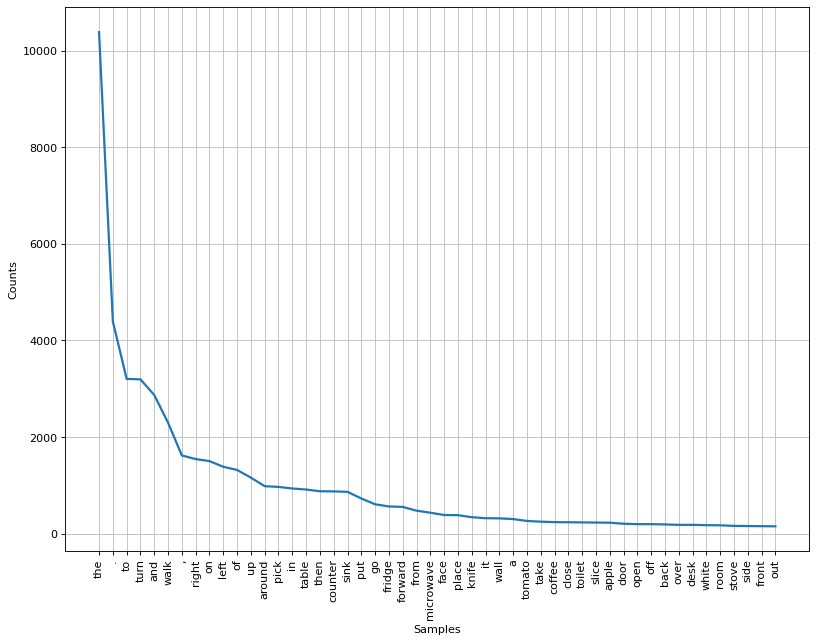

In [74]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
fd = nltk.FreqDist(v1_valid_seen_p_tokens)
fd.plot(50,cumulative=False)

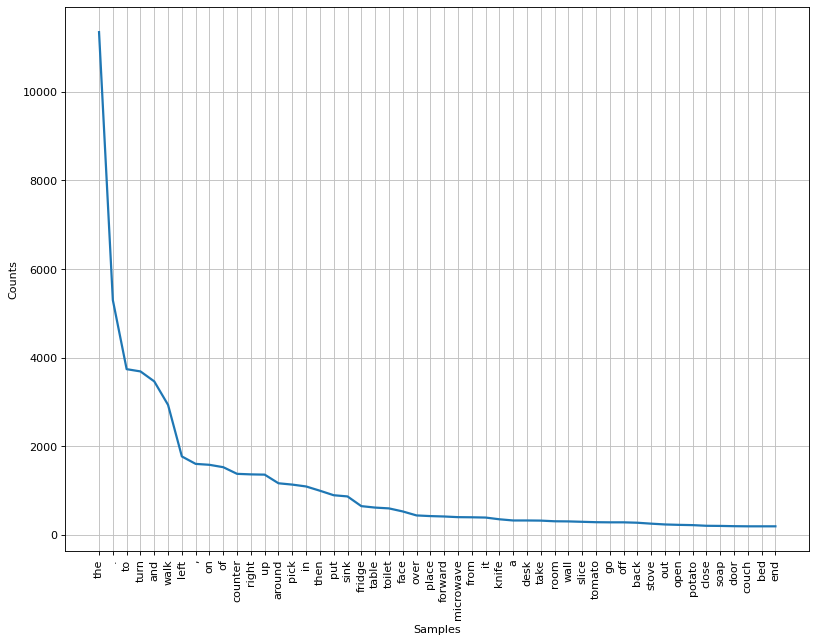

In [75]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
fd = nltk.FreqDist(v0_valid_seen_p_tokens)
fd.plot(50,cumulative=False)

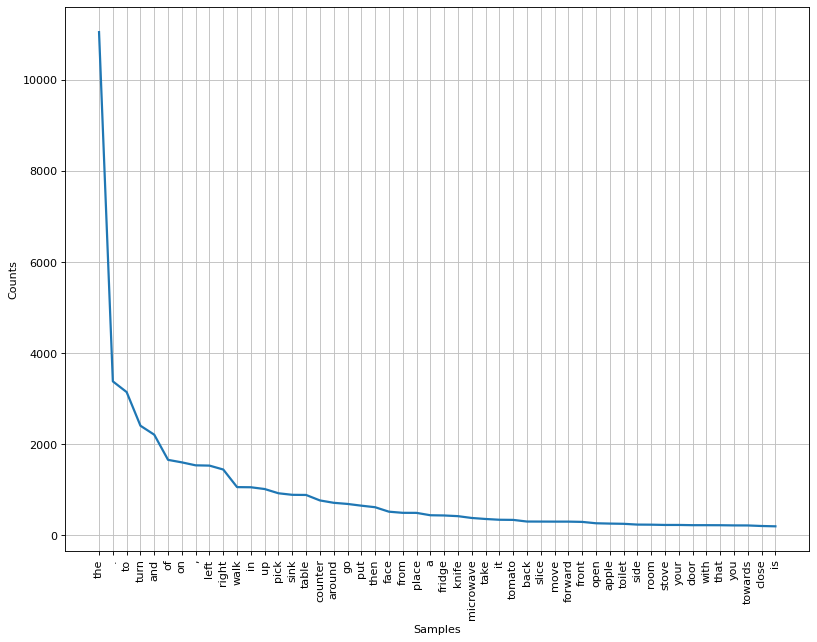

In [11]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
fd = nltk.FreqDist(valid_seen_ref_tokens)
fd.plot(50,cumulative=False)

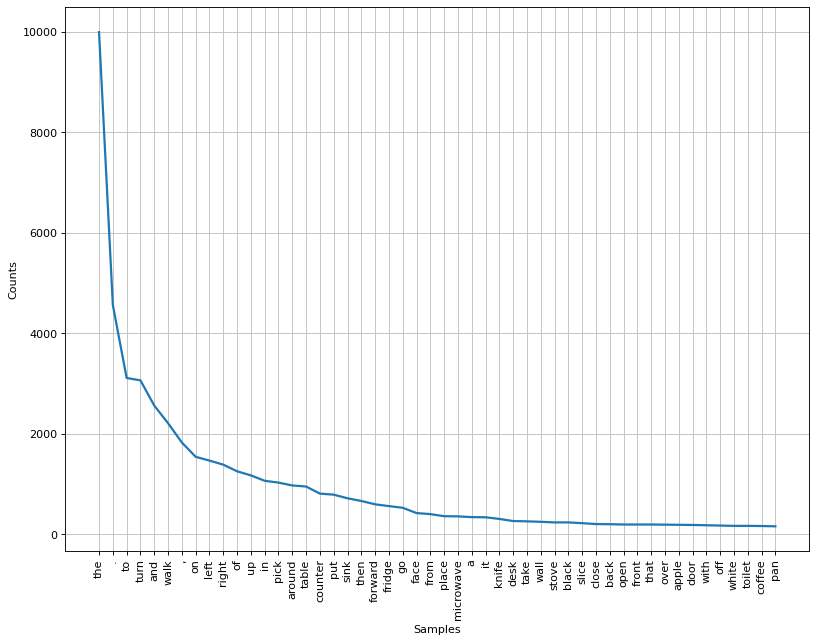

In [78]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
fd = nltk.FreqDist(v1_train_sanity_p_tokens)
fd.plot(50,cumulative=False)

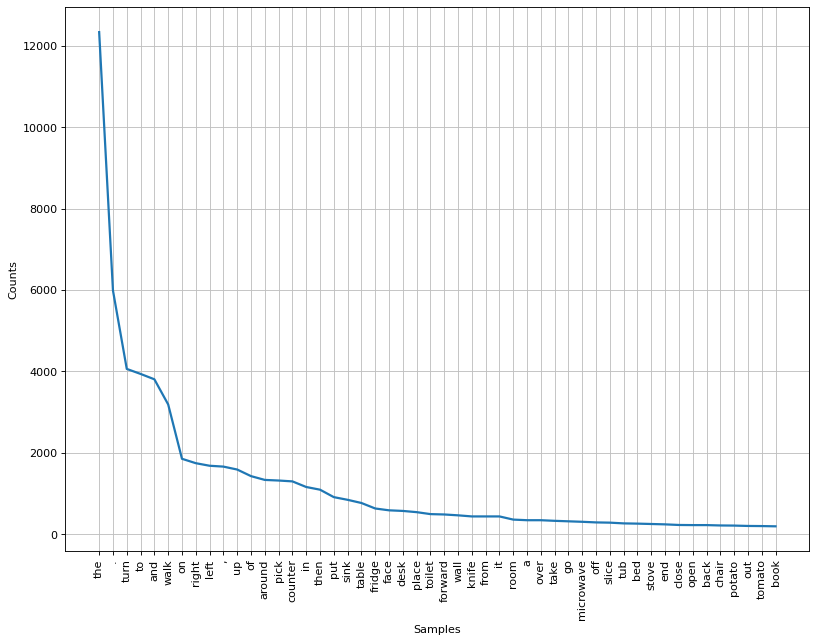

In [79]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
fd = nltk.FreqDist(v0_train_sanity_p_tokens)
fd.plot(50,cumulative=False)

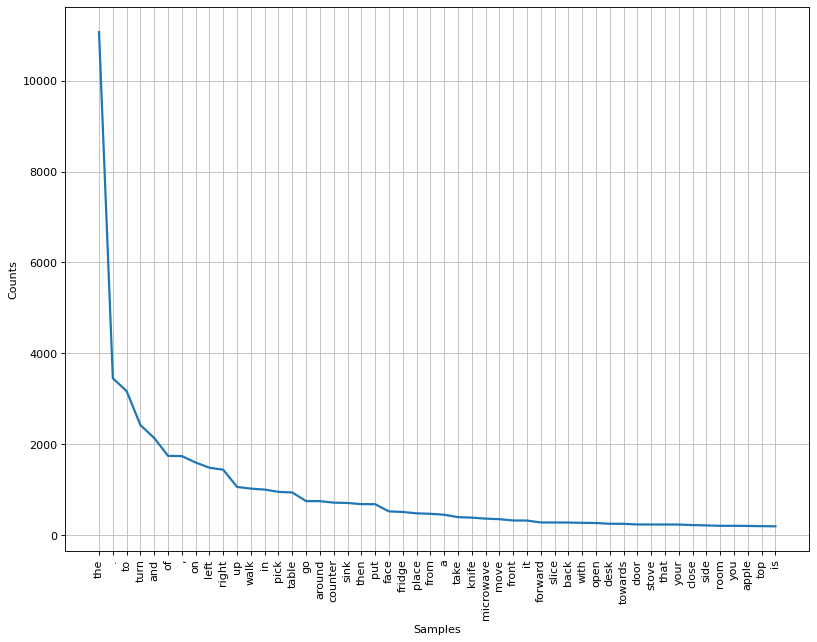

In [12]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
fd = nltk.FreqDist(train_sanity_ref_tokens)
fd.plot(50,cumulative=False)

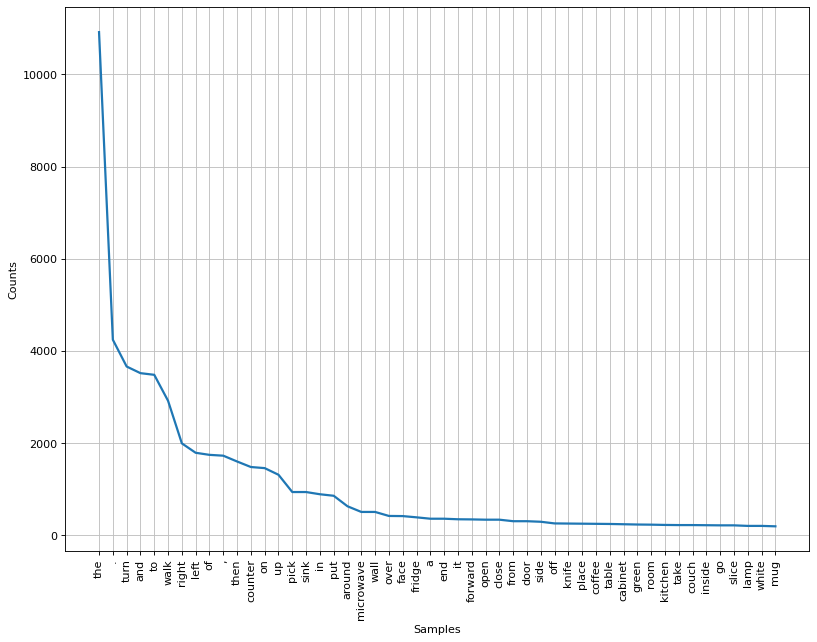

In [82]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
fd = nltk.FreqDist(v1_valid_unseen_p_tokens)
fd.plot(50,cumulative=False)

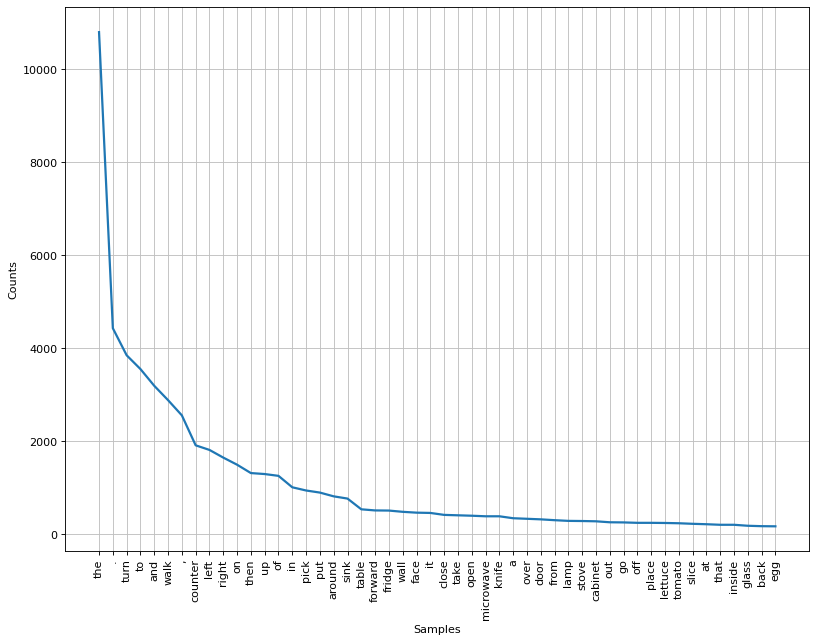

In [83]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
fd = nltk.FreqDist(v0_valid_unseen_p_tokens)
fd.plot(50,cumulative=False)

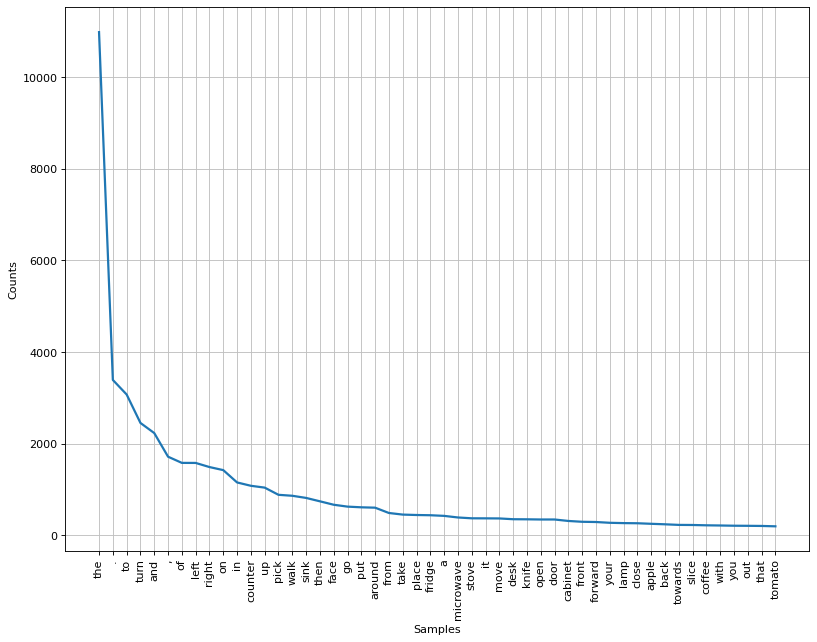

In [13]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')
fd = nltk.FreqDist(valid_unseen_ref_tokens)
fd.plot(50,cumulative=False)

## Compare word occurences

In [14]:
def compute_diff_dict(ref_vocab_normalized, p_vocab_normalized):
    diff = defaultdict(int)
    for word_type in ref_vocab_normalized:
        if word_type in p_vocab_normalized:
            diff[word_type] = ref_vocab_normalized[word_type] - p_vocab_normalized[word_type]
        else:
            diff[word_type] = ref_vocab_normalized[word_type]
    return diff

In [15]:
ref_train_sanity_vocab_normalized = {k : (v * 1.0 / sum(ref_train_sanity_vocab.values())) for (k,v) in ref_train_sanity_vocab.items()}
v1_train_sanity_p_vocab_normalized = {k : (v * 1.0 / sum(v1_train_sanity_p_vocab.values())) for (k,v) in v1_train_sanity_p_vocab.items()}
v0_train_sanity_p_vocab_normalized = {k : (v * 1.0 / sum(v0_train_sanity_p_vocab.values())) for (k,v) in v0_train_sanity_p_vocab.items()}

ref_valid_seen_vocab_normalized = {k : (v * 1.0 / sum(ref_valid_seen_vocab.values())) for (k,v) in ref_valid_seen_vocab.items()}
v1_valid_seen_p_vocab_normalized = {k : (v * 1.0 / sum(v1_valid_seen_p_vocab.values())) for (k,v) in v1_valid_seen_p_vocab.items()}
v0_valid_seen_p_vocab_normalized = {k : (v * 1.0 / sum(v0_valid_seen_p_vocab.values())) for (k,v) in v0_valid_seen_p_vocab.items()}

ref_valid_unseen_vocab_normalized = {k : (v * 1.0 / sum(ref_valid_unseen_vocab.values())) for (k,v) in ref_valid_unseen_vocab.items()}
v1_valid_unseen_p_vocab_normalized = {k : (v * 1.0 / sum(v1_valid_unseen_p_vocab.values())) for (k,v) in v1_valid_unseen_p_vocab.items()}
v0_valid_unseen_p_vocab_normalized = {k : (v * 1.0 / sum(v0_valid_unseen_p_vocab.values())) for (k,v) in v0_valid_unseen_p_vocab.items()}

In [16]:
v1_train_sanity_diff = compute_diff_dict(ref_train_sanity_vocab_normalized, v1_train_sanity_p_vocab_normalized)
v0_train_sanity_diff = compute_diff_dict(ref_train_sanity_vocab_normalized, v0_train_sanity_p_vocab_normalized)

v1_valid_seen_diff = compute_diff_dict(ref_valid_seen_vocab_normalized, v1_valid_seen_p_vocab_normalized)
v0_valid_seen_diff = compute_diff_dict(ref_valid_seen_vocab_normalized, v0_valid_seen_p_vocab_normalized)

v1_valid_unseen_diff = compute_diff_dict(ref_valid_unseen_vocab_normalized, v1_valid_unseen_p_vocab_normalized)
v0_valid_unseen_diff = compute_diff_dict(ref_valid_unseen_vocab_normalized, v0_valid_unseen_p_vocab_normalized)

In [17]:
# 
v1_train_sanity_diff_sorted = sorted([(k,v) for (k,v) in v1_train_sanity_diff.items()], key=lambda x:abs(x[1]), reverse=True)

In [18]:
def print_top_k_vocab_gap(ref_vocab_normalized, p_vocab_normalized, diff_dict, k=10):
    diff_sorted = sorted([(k,v) for (k,v) in diff_dict.items()], key=lambda x:abs(x[1]), reverse=True)
    line = '{:>12}  {:>12}  {:>12}  {:>12}'.format('word', '% in annotation', '% in predicted', 'difference')
    print(line)
    for (k,v) in diff_sorted[:k]:
        if k in p_vocab_normalized:
            line = '{:>12}  {:>12}  {:>12}  {:>12}'.format(k, round(ref_vocab_normalized[k],3), round(p_vocab_normalized[k],3), round(v,3))
        else:
            line = '{:>12}  {:>12}  {:>12}  {:>12}'.format(k, round(ref_vocab_normalized[k],3), 0.0, round(v,3))
        print(line)

In [19]:
# train_sanity V1
print_top_k_vocab_gap(ref_train_sanity_vocab_normalized, v1_train_sanity_p_vocab_normalized, v1_train_sanity_diff, k=50)

        word  % in annotation  % in predicted    difference
           .         0.056         0.078        -0.022
        walk         0.017         0.038        -0.021
        turn         0.039         0.053        -0.013
         and         0.035         0.044        -0.009
         the         0.179         0.172         0.008
          of         0.028         0.022         0.007
     forward         0.005          0.01        -0.006
      around         0.012         0.017        -0.005
     towards         0.004         0.001         0.003
        move         0.006         0.003         0.003
           ,         0.028         0.031        -0.003
          go         0.012         0.009         0.003
          up         0.017          0.02        -0.003
        your         0.004         0.001         0.003
         put         0.011         0.014        -0.002
        head         0.003           0.0         0.002
     counter         0.012         0.014        -0.002
     

In [24]:
# train_sanity V0
print_top_k_vocab_gap(ref_train_sanity_vocab_normalized, v0_train_sanity_p_vocab_normalized, v0_train_sanity_diff, k=50)

        word  % in annotation  % in predicted    difference
           .         0.056         0.084        -0.028
        walk         0.017         0.045        -0.028
         and         0.035         0.054        -0.019
        turn         0.039         0.057        -0.018
          of         0.028          0.02         0.008
          go         0.012         0.004         0.008
     counter         0.012         0.018        -0.007
      around         0.012         0.019        -0.007
        move         0.006           0.0         0.005
         the         0.179         0.174         0.005
          up         0.017         0.022        -0.005
           ,         0.028         0.023         0.005
       table         0.015         0.011         0.004
        then         0.011         0.015        -0.004
        wall         0.002         0.007        -0.004
          to         0.051         0.055        -0.004
      toilet         0.003         0.007        -0.004
     

In [23]:
# valid_seen V1
print_top_k_vocab_gap(ref_valid_seen_vocab_normalized, v1_valid_seen_p_vocab_normalized, v1_valid_seen_diff, k=50)

        word  % in annotation  % in predicted    difference
        walk         0.017         0.039        -0.022
           .         0.056         0.075        -0.019
        turn          0.04         0.055        -0.015
         and         0.036         0.049        -0.013
      around         0.012         0.017        -0.005
        then          0.01         0.015        -0.005
          of         0.027         0.023         0.005
         the         0.182         0.177         0.005
     forward         0.005         0.009        -0.004
        move         0.005         0.001         0.004
        wall         0.002         0.005        -0.003
          up         0.017          0.02        -0.003
          to         0.052         0.055        -0.003
refrigerator         0.003           0.0         0.003
        your         0.004         0.001         0.003
       right         0.024         0.026        -0.003
         you         0.004         0.001         0.002
     

In [21]:
# valid_seen V0
print_top_k_vocab_gap(ref_valid_seen_vocab_normalized, v0_valid_seen_p_vocab_normalized, v0_valid_seen_diff, k=50)

        word  % in annotation  % in predicted    difference
        walk         0.017         0.045        -0.027
           .         0.056         0.081        -0.025
        turn          0.04         0.056        -0.017
         and         0.036         0.053        -0.016
         the         0.182         0.173         0.008
     counter         0.013         0.021        -0.008
          go         0.011         0.004         0.007
      around         0.012         0.018        -0.006
          to         0.052         0.057        -0.005
       table         0.015         0.009         0.005
        then          0.01         0.015        -0.005
      toilet         0.004         0.009        -0.005
        over         0.002         0.007        -0.004
          of         0.027         0.023         0.004
          up         0.017         0.021        -0.004
        move         0.005         0.001         0.004
     towards         0.004           0.0         0.003
     

In [25]:
# valid_unseen V1
print_top_k_vocab_gap(ref_valid_unseen_vocab_normalized, v1_valid_unseen_p_vocab_normalized, v1_valid_unseen_diff, k=50)

        word  % in annotation  % in predicted    difference
        walk         0.014         0.045        -0.031
         and         0.037         0.055        -0.018
        turn         0.041         0.057        -0.017
        then         0.012         0.025        -0.013
         the         0.182          0.17         0.011
           .         0.056         0.066         -0.01
          go          0.01         0.003         0.007
       right         0.025         0.031        -0.006
        wall         0.002         0.008        -0.006
        move         0.006         0.001         0.005
     counter         0.018         0.023        -0.005
          in         0.019         0.014         0.005
       stove         0.006         0.001         0.005
        face         0.011         0.006         0.005
        over         0.002         0.007        -0.004
        take         0.007         0.003         0.004
         end         0.002         0.006        -0.004
     

In [26]:
# valid_unseen V0
print_top_k_vocab_gap(ref_valid_unseen_vocab_normalized, v0_valid_unseen_p_vocab_normalized, v0_valid_unseen_diff, k=50)

        word  % in annotation  % in predicted    difference
        walk         0.014         0.045        -0.031
        turn         0.041          0.06        -0.019
         the         0.182         0.169         0.013
           .         0.056         0.069        -0.013
         and         0.037          0.05        -0.013
     counter         0.018          0.03        -0.012
           ,         0.028          0.04        -0.011
        then         0.012          0.02        -0.008
       table         0.001         0.008        -0.007
          of         0.026          0.02         0.007
          go          0.01         0.004         0.006
        wall         0.002         0.007        -0.006
        move         0.006           0.0         0.006
          to         0.051         0.055        -0.005
        your         0.004           0.0         0.004
         put          0.01         0.014        -0.004
        face         0.011         0.007         0.004
     

In [173]:
missing_vocab_v1_train_sanity = set(ref_train_sanity_vocab.keys()) - set(v1_train_sanity_p_vocab.keys())
missing_vocab_v0_train_sanity = set(ref_train_sanity_vocab.keys()) - set(v0_train_sanity_p_vocab.keys())

missing_vocab_v1_valid_seen = set(ref_valid_seen_vocab.keys()) - set(v1_valid_seen_p_vocab.keys())
missing_vocab_v0_valid_seen = set(ref_valid_seen_vocab.keys()) - set(v0_valid_seen_p_vocab.keys())

missing_vocab_v1_valid_unseen = set(ref_valid_unseen_vocab.keys()) - set(v1_valid_unseen_p_vocab.keys())
missing_vocab_v0_valid_unseen = set(ref_valid_unseen_vocab.keys()) - set(v0_valid_unseen_p_vocab.keys())

In [195]:
len(ref_train_sanity_vocab.keys())

696

In [196]:
len(v1_train_sanity_p_vocab.keys())

301

In [197]:
len(v0_train_sanity_p_vocab.keys())

236

In [203]:
line = '{:>12}  {:>12}'.format('word', '% in annotation')
types = []
print(line)
for word_type in v0_valid_unseen_diff:
    if word_type in missing_vocab_v0_valid_unseen:
        types.append(word_type)
        line = '{:>12}  {:>12}'.format(word_type, ref_valid_unseen_vocab_normalized[word_type])
        print(line)
        
print(len(types))
print(len(missing_vocab_v0_valid_unseen))

        word  % in annotation
        hold  0.00022872453397376202
    <<stop>>  0.012498162034994854
      toward  0.0004901240013723472
    straight  0.0014867094708294532
       doors  0.0003104118675358199
       throw  9.802480027446944e-05
      return  0.00013069973369929258
      behind  0.0010946102697315754
   clockwise  1.6337466712411573e-05
    opposite  0.00016337466712411573
        near  0.0006371612017840514
      potted  1.6337466712411573e-05
       plant  6.534986684964629e-05
counterclockwise  1.6337466712411573e-05
   direction  3.2674933424823145e-05
       bring  0.0008332108023329902
        fill  0.00013069973369929258
      filled  9.802480027446944e-05
        full  3.2674933424823145e-05
       brown  0.00034308680096064307
       ahead  0.00045744906794752404
       begin  0.00021238706726135046
     walking  0.00022872453397376202
      before  0.00026139946739858516
     against  0.00019604960054893887
         far  0.0002450620006861736
        onto  0.

In [210]:
_,_,_,_,_,v1_train_sanity_n_pred_tokens,_,_,_ = preprocess_debug_data(v1_debug_train_sanity)
_,_,_,_,train_sanity_n_ref_tokens,v0_train_sanity_n_pred_tokens,train_sanity_n_subgoals,train_sanity_n_actions,_ = preprocess_debug_data(v0_debug_train_sanity)

In [211]:
_,_,_,_,_,v1_valid_seen_n_pred_tokens,_,_,_ = preprocess_debug_data(v1_debug_valid_seen)
_,_,_,_,valid_seen_n_ref_tokens,v0_valid_seen_n_pred_tokens,valid_seen_n_subgoals,valid_seen_n_actions,_ = preprocess_debug_data(v0_debug_valid_seen)

In [212]:
_,_,_,_,_,v1_valid_unseen_n_pred_tokens,_,_,_ = preprocess_debug_data(v1_debug_valid_unseen)
_,_,_,_,valid_unseen_n_ref_tokens,v0_valid_unseen_n_pred_tokens,valid_unseen_n_subgoals,valid_unseen_n_actions,_ = preprocess_debug_data(v0_debug_valid_unseen)

In [206]:
len(v0_valid_unseen_n_pred_tokens)

255

In [209]:
len(valid_unseen_n_ref_tokens)

255

(array([ 0.,  0.,  0.,  0.,  0.,  5., 14., 20., 24., 22., 13., 17., 18.,
        25., 20., 20., 13., 11.,  9.,  3.,  4.,  2.,  2.,  3.,  0.,  4.,
         1.,  0.,  2.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0.        ,   6.12244898,  12.24489796,  18.36734694,
         24.48979592,  30.6122449 ,  36.73469388,  42.85714286,
         48.97959184,  55.10204082,  61.2244898 ,  67.34693878,
         73.46938776,  79.59183673,  85.71428571,  91.83673469,
         97.95918367, 104.08163265, 110.20408163, 116.32653061,
        122.44897959, 128.57142857, 134.69387755, 140.81632653,
        146.93877551, 153.06122449, 159.18367347, 165.30612245,
        171.42857143, 177.55102041, 183.67346939, 189.79591837,
        195.91836735, 202.04081633, 208.16326531, 214.28571429,
        220.40816327, 226.53061224, 232.65306122, 238.7755102 ,
        244.89795918, 251.02040816, 257.14285714, 263.26530612,
        269.38775

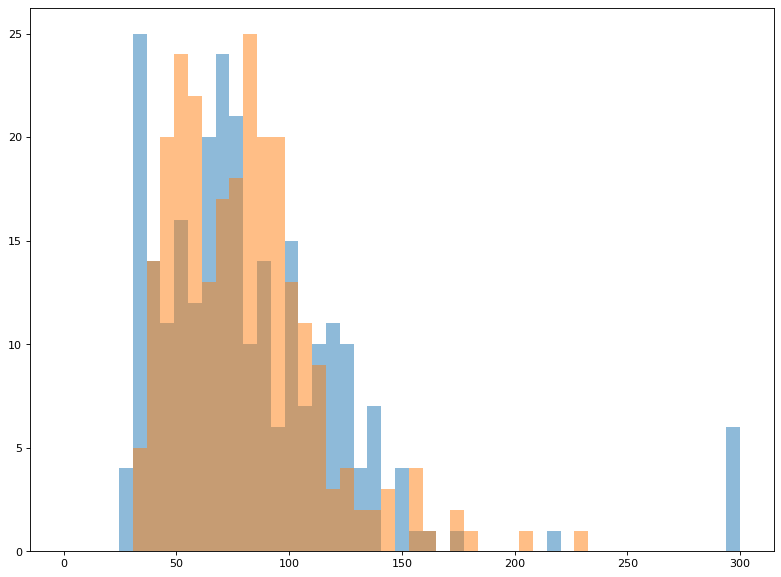

In [225]:
figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

bins = np.linspace(0, 300, 50)
plt.hist(v0_valid_unseen_n_pred_tokens, bins=bins, alpha=0.5)
plt.hist(valid_unseen_n_ref_tokens, bins=bins, alpha=0.5)

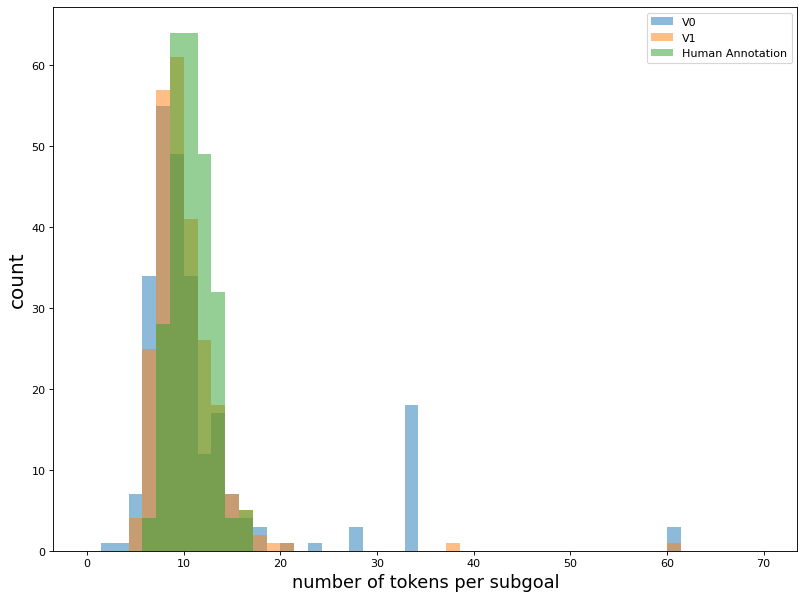

In [236]:
# Train Sanity

figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

bins = np.linspace(0, 70, 50)
plt.hist(np.array(v0_train_sanity_n_pred_tokens) / train_sanity_n_subgoals, bins=bins, alpha=0.5, label='V0')
plt.hist(np.array(v1_train_sanity_n_pred_tokens) / train_sanity_n_subgoals, bins=bins, alpha=0.5, label='V1')
plt.hist(np.array(train_sanity_n_ref_tokens) / train_sanity_n_subgoals, bins=bins, alpha=0.5, label='Human Annotation')
plt.ylabel('count', fontsize=18)
plt.xlabel('number of tokens per subgoal', fontsize=16)
plt.legend(loc='upper right')

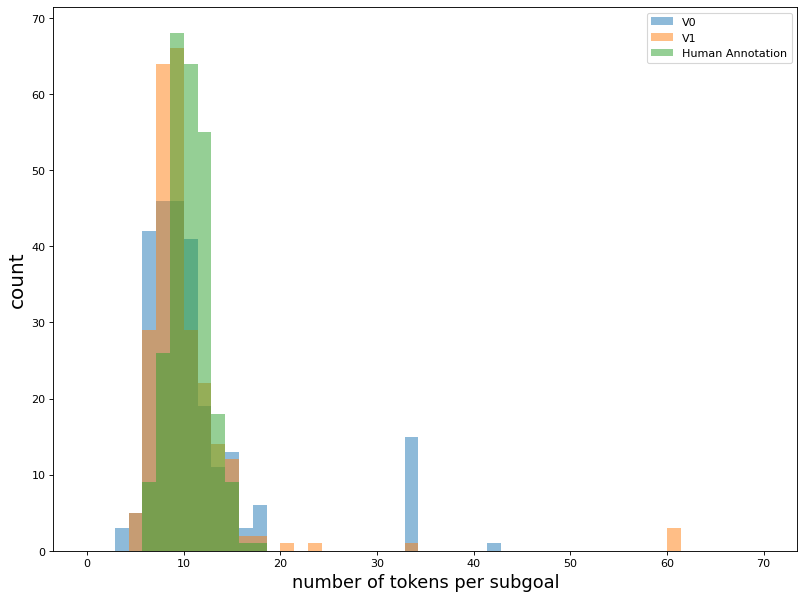

In [235]:
# Valid Seen

figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

bins = np.linspace(0, 70, 50)
plt.hist(np.array(v0_valid_seen_n_pred_tokens) / valid_seen_n_subgoals, bins=bins, alpha=0.5, label='V0')
plt.hist(np.array(v1_valid_seen_n_pred_tokens) / valid_seen_n_subgoals, bins=bins, alpha=0.5, label='V1')
plt.hist(np.array(valid_seen_n_ref_tokens) / valid_seen_n_subgoals, bins=bins, alpha=0.5, label='Human Annotation')
plt.ylabel('count', fontsize=18)
plt.xlabel('number of tokens per subgoal', fontsize=16)
plt.legend(loc='upper right')

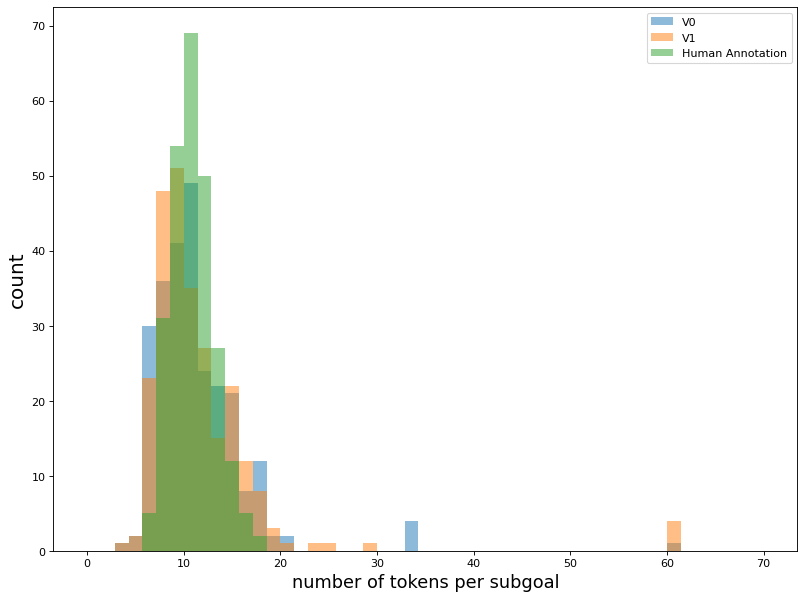

In [234]:
# Valid Unseen

figure(num=None, figsize=(12, 9), dpi=80, facecolor='w', edgecolor='k')

bins = np.linspace(0, 70, 50)
plt.hist(np.array(v0_valid_unseen_n_pred_tokens) / valid_unseen_n_subgoals, bins=bins, alpha=0.5, label='V0')
plt.hist(np.array(v1_valid_unseen_n_pred_tokens) / valid_unseen_n_subgoals, bins=bins, alpha=0.5, label='V1')
plt.hist(np.array(valid_unseen_n_ref_tokens) / valid_unseen_n_subgoals, bins=bins, alpha=0.5, label='Human Annotation')
plt.ylabel('count', fontsize=18)
plt.xlabel('number of tokens per subgoal', fontsize=16)
plt.legend(loc='upper right')